<a href="https://colab.research.google.com/github/Shrey-Viradiya/DiveDeep/blob/master/Prac7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prac 7 : Autoencoders


### 18BCE259

In [1]:
!nvidia-smi

Sat May  1 15:40:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    73W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from time import time

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Performing PCA with an Undercomplete Linear Autoencoder

In [5]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape = [3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape = [2]))
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss = 'mse', optimizer=keras.optimizers.SGD(lr=0.5))

### Generate 3D data for training

In [6]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [7]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [8]:
history = autoencoder.fit(X_train, X_train, epochs = 20)
coding = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 1s 8ms/step - loss: 0.1155
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0224
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0151
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 9/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0141
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0144
Epoch 11/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 12/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.

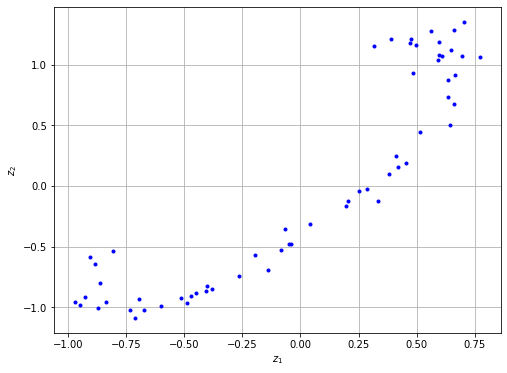

In [9]:
fig = plt.figure(figsize=(8,6))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = 'selu'),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])    
])

stacked_AE = keras.models.Sequential([stacked_encoder, stacked_decoder])

'''
When compiling the stacked autoencoder, we use the binary cross-entropy 
loss instead of the mean squared error. We are treating the 
reconstruction task as a multilabel binary classification problem: 
each pixel intensity represents the probability that the pixel 
should be black. Framing it this way (rather than as a regression 
problem) tends to make the model converge faster.
'''
stacked_AE.compile(loss='binary_crossentropy', optimizer= keras.optimizers.SGD(lr = 1.5),
                  metrics = [rounded_accuracy])

In [14]:
history = stacked_AE.fit(X_train, X_train, epochs= 20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3952 - rounded_accuracy: 0.8460 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3070 - rounded_accuracy: 0.9176 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2967 - rounded_accuracy: 0.9267 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2906 - rounded_accuracy: 0.9328 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2860 - rounded_accuracy: 0.9372 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2844 - rounded_accuracy: 0.9396 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/20
1719/1719 [==================

In [15]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [16]:
def show_reconstructions(AE,images=X_valid, n_images=5):
    reconstructions = AE.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

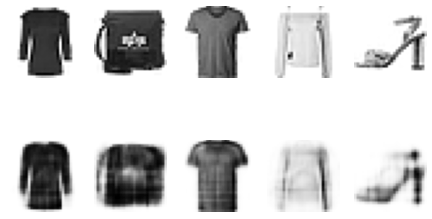

In [17]:
show_reconstructions(stacked_AE)

In [18]:
encT_100 = stacked_encoder.predict(X_train)
encV_100 = stacked_encoder.predict(X_valid)

In [19]:
stacked_encoder_2 = keras.models.Sequential([
    keras.layers.Dense(50, activation = 'selu', input_shape = (100,)),
])

stacked_decoder_2 = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape = (50,)),
])

stacked_AE_2 = keras.models.Sequential([stacked_encoder_2, stacked_decoder_2])

stacked_AE_2.compile(loss='mse', optimizer= keras.optimizers.SGD(lr = 0.0005),
                  metrics = ['accuracy'])

In [20]:
history = stacked_AE_2.fit(encT_100, encT_100, epochs= 20, validation_data=(encV_100, encV_100))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 6.2750 - accuracy: 0.1120 - val_loss: 2.5611 - val_accuracy: 0.4002
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 2.2876 - accuracy: 0.4384 - val_loss: 1.6818 - val_accuracy: 0.4990
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1.5682 - accuracy: 0.5030 - val_loss: 1.3717 - val_accuracy: 0.5276
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3084 - accuracy: 0.5261 - val_loss: 1.1968 - val_accuracy: 0.5464
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1485 - accuracy: 0.5482 - val_loss: 1.0767 - val_accuracy: 0.5626
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0406 - accuracy: 0.5701 - val_loss: 0.9856 - val_accuracy: 0.5830
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9557 - accuracy: 0.5918 - val_loss: 0.9142 - val_accuracy:

In [21]:
clf = keras.models.Sequential([
    keras.layers.Dense(10, activation = 'softmax', input_shape = (50,)),
])

classifier = keras.models.Sequential([stacked_encoder, stacked_encoder_2, clf])

classifier.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1.5), metrics = ['accuracy'])
classifier.fit(X_train, y_train, epochs = 20)

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1257.0729 - accuracy: 0.1001
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 17.9600 - accuracy: 0.1024
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 30.8326 - accuracy: 0.1011
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 45.1321 - accuracy: 0.1031
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 59.3692 - accuracy: 0.1046
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 69.1343 - accuracy: 0.0971
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 70.9484 - accuracy: 0.0988
Epoch 8/20
1719/1719 [==============================] - 5s 3ms/step - loss: 77.4071 - accuracy: 0.0998
Epoch 9/20
1719/1719 [==============================] - 5s 3ms/step - loss: 76.0128 - accuracy: 0.0979
Epoch 10/20
1719/1719 [==============================] - 5s 3ms/step - 

## Convolutional Autoencoders

In [22]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                                activation='selu',
                                input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                                activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                                activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

conv_AE = keras.models.Sequential([conv_encoder, conv_decoder])

In [23]:
conv_AE.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_AE.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 40s 7ms/step - loss: 0.3347 - rounded_accuracy: 0.8913 - val_loss: 0.2834 - val_rounded_accuracy: 0.9316
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2781 - rounded_accuracy: 0.9389 - val_loss: 0.2734 - val_rounded_accuracy: 0.9454
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2722 - rounded_accuracy: 0.9447 - val_loss: 0.2748 - val_rounded_accuracy: 0.9397
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2695 - rounded_accuracy: 0.9479 - val_loss: 0.2687 - val_rounded_accuracy: 0.9491
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2673 - rounded_accuracy: 0.9502 - val_loss: 0.2670 - val_rounded_accuracy: 0.9513


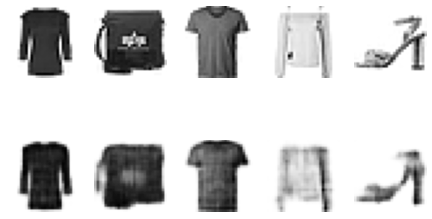

In [24]:
show_reconstructions(conv_AE)

## Denoising Autoencoders

In [25]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [26]:
dropout_AE = keras.models.Sequential([
    dropout_encoder, dropout_decoder
])

In [27]:
dropout_AE.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr = 1.0), metrics=[rounded_accuracy])
history = dropout_AE.fit(X_train, X_train, epochs = 10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4076 - rounded_accuracy: 0.8262 - val_loss: 0.3207 - val_rounded_accuracy: 0.9046
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3210 - rounded_accuracy: 0.9009 - val_loss: 0.3117 - val_rounded_accuracy: 0.9111
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3134 - rounded_accuracy: 0.9065 - val_loss: 0.3065 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3095 - rounded_accuracy: 0.9098 - val_loss: 0.3038 - val_rounded_accuracy: 0.9186
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3063 - rounded_accuracy: 0.9127 - val_loss: 0.3009 - val_rounded_accuracy: 0.9196
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3055 - rounded_accuracy: 0.9138 - val_loss: 0.3006 - val_rounded_accuracy: 0.9175
Epoch 7/10
1719/1719 [==================

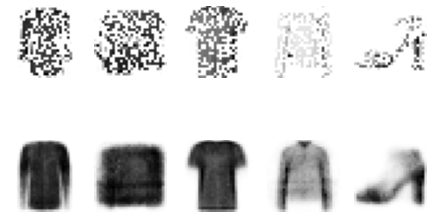

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.Dropout(0.5)
show_reconstructions(dropout_AE, noise(X_valid, training=True))
plt.show()

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [30]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4007 - rounded_accuracy: 0.8323 - val_loss: 0.3182 - val_rounded_accuracy: 0.9036
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3146 - rounded_accuracy: 0.9075 - val_loss: 0.3087 - val_rounded_accuracy: 0.9156
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3067 - rounded_accuracy: 0.9141 - val_loss: 0.3035 - val_rounded_accuracy: 0.9191
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3032 - rounded_accuracy: 0.9173 - val_loss: 0.2999 - val_rounded_accuracy: 0.9207
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2998 - rounded_accuracy: 0.9205 - val_loss: 0.2968 - val_rounded_accuracy: 0.9252
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2985 - rounded_accuracy: 0.9222 - val_loss: 0.2947 - val_rounded_accuracy: 0.9272
Epoch 7/10
1719/1719 [==================

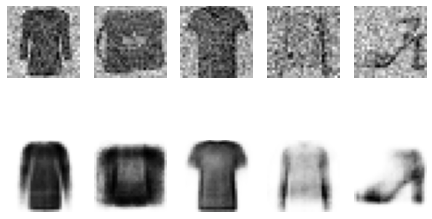

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()